## Header Files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Header Files

In [ ]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt

%matplotlib inline

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from collections import Counter

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras import layers, regularizers
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D,Dropout

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

lemmatizer = WordNetLemmatizer()
stop = stopwords.words('english')
stop.extend(['@', '.', '#', 'user'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Loading Data and Sanity Checks

In [ ]:
train_data_add = "/content/drive/MyDrive/Data/dataset.csv"
train_data = pd.read_csv(train_data_add)

## Checking Data

In [ ]:
print("Training Data")
print(train_data.head(3))
print("Length of Test data = ", len(train_data))
train_data.head(5)

Training Data
                  selected_text  sentiment
0  have responded if were going          0
1                      sooo sad          1
2                   bullying me          1
Length of Test data =  27481


,selected_text,sentiment
0,have responded if were going,0
1,sooo sad,1
2,bullying me,1
3,leave me alone,1
4,sons of,1


# Pre-Procesing


            Pre-processing of data
    0) Making Every tweet to lowercase
    1) Tokenization
    2) Stop Word 
    3) Lemmatization

## Converting to Lower Case

In [ ]:
# Converting to Lower Case
count=0
for i in range(len(train_data)):
  try:
    train_data.iloc[i, 0] = train_data.iloc[i, 0].lower()
  except:
    train_data.iloc[i, 0] = str(train_data.iloc[i, 0]).lower()
    pass
train_data

,selected_text,sentiment
0,have responded if were going,0
1,sooo sad,1
2,bullying me,1
3,leave me alone,1
4,sons of,1
...,...,...
27476,lost,1
27477,don force,1
27478,yay good for both of you,2
27479,but it was worth it,2


## Tokenization

In [ ]:
tokens = []
for i in range(len(train_data)):
    tokens.append(nltk.word_tokenize(train_data.iloc[i, 0]))
print("After Tokenizing          : ", tokens[0])

After Tokenizing          :  ['have', 'responded', 'if', 'were', 'going']


## Stop Word Removal

In [ ]:
filtered_tokens = []
for i in range(len(tokens)):
    filtered_tokens.append([word for word in tokens[i] if word not in stop])
print("After Removing Stop Words : ", filtered_tokens[0])

After Removing Stop Words :  ['responded', 'going']


## Lemmatization

In [ ]:
lemmatizers = []
for i in range(len(filtered_tokens)):
    lemmatizers.append([lemmatizer.lemmatize(word) for word in filtered_tokens[i]])
print("After Lemmatization       : ", lemmatizers[0])

After Lemmatization       :  ['responded', 'going']


In [ ]:
total_words=[]
for i in range(len(lemmatizers)):
    total_words.extend(lemmatizers[i])

## Extra Tokenizer

In [ ]:
tokenizer = Tokenizer(
    num_words = len(total_words),
    filters = '"#$%&()*+-/:,;<=>@[\]^_`{|}~'
)
tokenizer.fit_on_texts(lemmatizers)

# Pictorial Analysis of Word Lengths

(array([1.3884e+04, 5.0010e+03, 4.0760e+03, 1.7370e+03, 1.8200e+03,
        6.4600e+02, 2.9500e+02, 1.9000e+01, 2.0000e+00, 1.0000e+00]),
 array([ 0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. , 22.5, 25. ]),
 <a list of 10 Patch objects>)

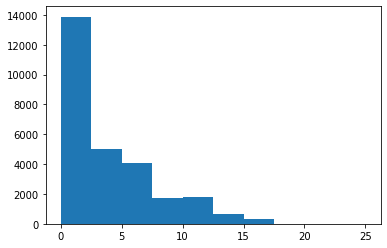

In [ ]:
"""
 The next step currently is converting these words into numbers based on occurances and padding with zeros for length  
"""
word_lengths = []
for i in range(len(lemmatizers)):
  word_lengths.append(len(lemmatizers[i]))
mean = sum(word_lengths)/len(word_lengths)
plt.hist(word_lengths)

In [ ]:
# Over here The max_length represents the max length of phrase taken inro consideration
max_len = int(mean)
max_len

3

# One Hot Encoding of the Data

In [ ]:
pos = []
mid = []
neg = []
for l in range(len(train_data.iloc[:,1])):
    if train_data.iloc[l,1] == 0:
        pos.append(0)
        mid.append(0)
        neg.append(1)
    elif train_data.iloc[l,1] == 1:
        pos.append(0)
        mid.append(1)
        neg.append(0)
    else:
      pos.append(1)
      mid.append(0)
      neg.append(0)
train_data['Pos']= pos
train_data['Mid']= mid
train_data["Neg"]= neg
train_data

,selected_text,sentiment,Pos,Mid,Neg
0,have responded if were going,0,0,0,1
1,sooo sad,1,0,1,0
2,bullying me,1,0,1,0
3,leave me alone,1,0,1,0
4,sons of,1,0,1,0
...,...,...,...,...,...
27476,lost,1,0,1,0
27477,don force,1,0,1,0
27478,yay good for both of you,2,1,0,0
27479,but it was worth it,2,1,0,0


# Finding Highest frequency of words and creating the int dict

In [ ]:
lemmatizers_to_int = Counter(total_words)
total_word_count = len(total_words)
print(total_word_count)

107198


In [ ]:
sorted_order = lemmatizers_to_int.most_common(total_word_count)
print(lemmatizers_to_int)
print(sorted_order[0][0])

Counter({'day': 1291, 'good': 1261, 'love': 979, 'happy': 856, 'get': 831, 'like': 797, 'go': 750, 'got': 660, 'work': 659, 'time': 623, 'going': 597, 'today': 586, 'one': 586, 'lol': 574, 'thanks': 543, 'miss': 537, 'really': 520, 'know': 509, 'back': 495, 'want': 491, 'great': 481, 'im': 476, 'fun': 450, 'see': 448, 'sad': 431, 'sorry': 426, 'home': 422, 'well': 418, 'night': 415, 'hope': 414, 'think': 401, 'bad': 396, 'new': 381, 'feel': 381, 'still': 380, 'much': 374, 'na': 374, 'mother': 374, 'need': 367, 'wish': 357, 'nice': 352, 'oh': 340, 'make': 330, 'hate': 321, 'haha': 312, 'morning': 309, 'last': 306, 'week': 297, 'twitter': 290, 'awesome': 283, 'would': 278, 'better': 270, 'tomorrow': 262, 'thing': 261, 'look': 259, 'right': 258, 'come': 257, 'suck': 252, 'yeah': 238, 'way': 232, 'tonight': 231, 'best': 228, 'say': 228, 'gon': 222, 'tired': 222, 'though': 221, 'thank': 220, 'getting': 218, 'dont': 217, 'sick': 216, 'friend': 214, 'sleep': 214, 'wait': 201, 'people': 200, '

In [ ]:
vocab_to_index = {w: i+1 for i, (w, c) in enumerate(sorted_order)}
print(vocab_to_index)

{'day': 1, 'good': 2, 'love': 3, 'happy': 4, 'get': 5, 'like': 6, 'go': 7, 'got': 8, 'work': 9, 'time': 10, 'going': 11, 'today': 12, 'one': 13, 'lol': 14, 'thanks': 15, 'miss': 16, 'really': 17, 'know': 18, 'back': 19, 'want': 20, 'great': 21, 'im': 22, 'fun': 23, 'see': 24, 'sad': 25, 'sorry': 26, 'home': 27, 'well': 28, 'night': 29, 'hope': 30, 'think': 31, 'bad': 32, 'new': 33, 'feel': 34, 'still': 35, 'much': 36, 'na': 37, 'mother': 38, 'need': 39, 'wish': 40, 'nice': 41, 'oh': 42, 'make': 43, 'hate': 44, 'haha': 45, 'morning': 46, 'last': 47, 'week': 48, 'twitter': 49, 'awesome': 50, 'would': 51, 'better': 52, 'tomorrow': 53, 'thing': 54, 'look': 55, 'right': 56, 'come': 57, 'suck': 58, 'yeah': 59, 'way': 60, 'tonight': 61, 'best': 62, 'say': 63, 'gon': 64, 'tired': 65, 'though': 66, 'thank': 67, 'getting': 68, 'dont': 69, 'sick': 70, 'friend': 71, 'sleep': 72, 'wait': 73, 'people': 74, 'cool': 75, 'weekend': 76, 'hurt': 77, 'could': 78, 'next': 79, 'hour': 80, 'bed': 81, 'never'

## Encoding to numbers

In [ ]:
num_encoded_reviews = []
for i in range(len(lemmatizers)):
    num_encoded_reviews.append([vocab_to_index[word] for word in lemmatizers[i]])
print(num_encoded_reviews)
print(max(train_data.iloc[:,1]))

[[6198, 11], [298, 25], [6199], [231, 407], [764], [6200, 4196, 62, 3268, 4197, 1637], [23], [347, 448], [], [129, 2326, 2693], [36, 3, 2041, 2694, 470, 4198, 82, 64, 37, 5, 453, 224], [6], [6201], [163], [358, 358, 4199, 6202], [1102, 42, 2042], [539], [70], [6203], [894], [42, 6204, 26, 30, 108, 91], [348], [487, 148, 269, 4200, 201, 12], [8, 171, 4201, 365, 134, 270, 540, 232, 253, 2327, 6205], [24, 1047, 168, 480, 6206, 6207, 460, 1103, 6208, 120, 983], [271, 6209, 895, 499, 23, 22, 1388], [26], [320], [23], [782, 19, 85], [341, 2695], [30], [28, 36, 1638, 280], [162], [683, 616, 205, 64, 37, 195, 62, 131, 53, 66, 30, 183, 2328], [206, 253, 984, 1277], [16], [705, 617, 17, 334, 12, 236, 2043, 1104, 33, 373, 354, 349, 3269], [1278, 6210], [87, 4, 706], [154, 4, 174, 174, 6211, 1389, 355, 4202, 11, 471, 2329, 500, 191], [6212, 258], [3270], [6213, 1799, 2696, 783, 13, 54, 985, 4203, 6, 35, 23, 83, 6214, 2697, 32, 259, 55], [3], [110, 196, 6215, 1508, 635, 6216, 4204, 145, 34], [6217]

## Padding and truncating

In [ ]:
padded_reviews = pad_sequences(num_encoded_reviews, maxlen=max_len)
print(padded_reviews)

[[   0 6198   11]
 [   0  298   25]
 [   0    0 6199]
 ...
 [   0  121    2]
 [   0    0  444]
 [ 513  121  315]]


# Modelling and Training

In [ ]:
# X_train and Y_train
X_train = np.array(padded_reviews[0:int(len(padded_reviews)*0.9)])
Y_train = train_data.loc[0:int(len(padded_reviews)*0.9),["Pos","Mid","Neg"]]

# X_test and Y_test
X_test = np.array(padded_reviews[int(len(padded_reviews)*0.9):])
Y_test = train_data.loc[int(len(padded_reviews)*0.9):len(padded_reviews),["Pos","Mid","Neg"]]


checkpoint1_Model1 = ModelCheckpoint("best_mode1_15-02-2021.hdf5",monitor='accuracy',save_best_only = True, save_weights_only= False)
checkpoint1_Model2 = ModelCheckpoint("best_mode2_15-02-2021.hdf5",monitor='accuracy',save_best_only = True, save_weights_only= False)

## Model 1

In [ ]:
# Now we are ready to train our model through LSTM network
model = Sequential()
model.add(layers.Embedding(len(vocab_to_index)+1,output_dim = 45,input_length = max_len))
model.add(SpatialDropout1D(0.3))
model.add(layers.LSTM(45))
model.add(layers.Dense(10,activation = 'relu', input_shape=(45,)))
model.add(layers.Dense(3,activation='softmax', input_shape=(10,)))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 3, 45)             667350    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 3, 45)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 45)                16380     
_________________________________________________________________
dense (Dense)                (None, 10)                460       
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 33        
Total params: 684,223
Trainable params: 684,223
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Our vectorized labels
model.fit(X_train, Y_train ,validation_split =0.2, epochs=16, callbacks=[checkpoint1_Model1], verbose=1 )

Epoch 1/16
619/619 [==============================] - 9s 11ms/step - loss: 0.8794 - accuracy: 0.6206 - val_loss: 0.5696 - val_accuracy: 0.7807
Epoch 2/16
619/619 [==============================] - 6s 10ms/step - loss: 0.4906 - accuracy: 0.8147 - val_loss: 0.5718 - val_accuracy: 0.7768
Epoch 3/16
619/619 [==============================] - 6s 11ms/step - loss: 0.3850 - accuracy: 0.8628 - val_loss: 0.5999 - val_accuracy: 0.7708
Epoch 4/16
619/619 [==============================] - 6s 10ms/step - loss: 0.3242 - accuracy: 0.8847 - val_loss: 0.6351 - val_accuracy: 0.7611
Epoch 5/16
619/619 [==============================] - 6s 10ms/step - loss: 0.2839 - accuracy: 0.8979 - val_loss: 0.6660 - val_accuracy: 0.7671
Epoch 6/16
619/619 [==============================] - 6s 10ms/step - loss: 0.2736 - accuracy: 0.9002 - val_loss: 0.7137 - val_accuracy: 0.7607
Epoch 7/16
619/619 [==============================] - 6s 10ms/step - loss: 0.2403 - accuracy: 0.9108 - val_loss: 0.7445 - val_accuracy: 0.7584

## Model 2

In [ ]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim = len(vocab_to_index)+1, output_dim = 256, input_length = max_len))
model_lstm.add(SpatialDropout1D(0.3))
model_lstm.add(LSTM(256, dropout = 0.3, recurrent_dropout = 0.3))
model_lstm.add(Dense(256, activation = 'relu'))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(3, activation = 'softmax'))
model_lstm.compile(
    loss='categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 3, 256)            3796480   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 3, 256)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 771       
Total params: 4,388,355
Trainable params: 4,388,355
Non-trainable params: 0
____________________________________________

In [ ]:
history = model_lstm.fit(
    X_train,
    Y_train,
    validation_split = 0.2,
    epochs = 16,
    batch_size = 512,
    callbacks = [checkpoint1_Model2]
)

Epoch 1/16
39/39 [==============================] - 11s 218ms/step - loss: 0.9952 - accuracy: 0.5468 - val_loss: 0.6644 - val_accuracy: 0.7623
Epoch 2/16
39/39 [==============================] - 8s 209ms/step - loss: 0.5725 - accuracy: 0.7845 - val_loss: 0.5636 - val_accuracy: 0.7821
Epoch 3/16
39/39 [==============================] - 8s 208ms/step - loss: 0.4304 - accuracy: 0.8433 - val_loss: 0.5761 - val_accuracy: 0.7766
Epoch 4/16
39/39 [==============================] - 8s 209ms/step - loss: 0.3735 - accuracy: 0.8651 - val_loss: 0.6043 - val_accuracy: 0.7679
Epoch 5/16
39/39 [==============================] - 8s 208ms/step - loss: 0.3308 - accuracy: 0.8838 - val_loss: 0.6446 - val_accuracy: 0.7687
Epoch 6/16
39/39 [==============================] - 8s 209ms/step - loss: 0.2870 - accuracy: 0.8984 - val_loss: 0.6589 - val_accuracy: 0.7609
Epoch 7/16
39/39 [==============================] - 8s 208ms/step - loss: 0.2793 - accuracy: 0.8981 - val_loss: 0.6904 - val_accuracy: 0.7619
Epoch

# Evaluation

## Model 1

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, Y_test, batch_size=128)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(X_test[:1])
print("predictions shape:", predictions.shape)

Evaluate on test data
22/22 [==============================] - 0s 2ms/step - loss: 0.9855 - accuracy: 0.7312
test loss, test acc: [0.9855080246925354, 0.7311749458312988]
Generate predictions for 3 samples
predictions shape: (1, 3)


In [ ]:
np.around(predictions,2) ,np.array(Y_test[:1])

(array([[0.09, 0.01, 0.91]], dtype=float32), array([[0, 0, 1]]))

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model_lstm.evaluate(X_test, Y_test, batch_size=128)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model_lstm.predict(X_test[:5])
print("predictions shape:", predictions.shape)

Evaluate on test data
22/22 [==============================] - 0s 15ms/step - loss: 0.9817 - accuracy: 0.7432
test loss, test acc: [0.9817171692848206, 0.7431793212890625]
Generate predictions for 3 samples
predictions shape: (5, 3)


In [ ]:
np.around(predictions,2), np.array(Y_test[:5])

(array([[0.19, 0.02, 0.79],
        [0.  , 0.35, 0.65],
        [0.99, 0.  , 0.  ],
        [0.96, 0.03, 0.  ],
        [0.44, 0.01, 0.55]], dtype=float32), array([[0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [1, 0, 0],
        [0, 0, 1]]))

In [ ]:
"""
A different model using naive bais classifier

ping=[]
#featuresets = [(find_features(rev), category) for (rev, category) in documents]

for i in range(len(num_encoded_reviews)):
    ping.append((padded_reviews[i],train_data.iloc[:,1]))
random.shuffle(ping)

training_set = ping[:int(len(ping)*0.8)]
testing_set = ping[int(len(ping)*0.8):]

classifier = nltk.NaiveBayesClassifier.train(training_set)

print("Classifier accuracy percent:",(nltk.classify.accuracy(classifier, testing_set))*100)

classifier.show_most_informative_features(15)"""

'\nA different model using naive bais classifier\n\nping=[]\n#featuresets = [(find_features(rev), category) for (rev, category) in documents]\n\nfor i in range(len(num_encoded_reviews)):\n    ping.append((padded_reviews[i],train_data.iloc[:,1]))\nrandom.shuffle(ping)\n\ntraining_set = ping[:int(len(ping)*0.8)]\ntesting_set = ping[int(len(ping)*0.8):]\n\nclassifier = nltk.NaiveBayesClassifier.train(training_set)\n\nprint("Classifier accuracy percent:",(nltk.classify.accuracy(classifier, testing_set))*100)\n\nclassifier.show_most_informative_features(15)'